# Import packs

In [3]:
!pip install xgboost

  Using cached xgboost-1.4.2-py3-none-manylinux2010_x86_64.whl (166.7 MB)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler , FunctionTransformer,OneHotEncoder
from sklearn.compose import make_column_selector,ColumnTransformer

from From_Shelter_to_Love.data_provisoria import get_data

# Animal and Features

In [3]:
Animal = "Cat"
features = ['Intake Type','Intake Condition','Breed','age_upon_intake_months','neutered_or_spayed_intake','male_or_female_intake','group_color']


# Creating targets

In [4]:
def classifier_y0(df,column):
    target = []
    for days in df[column]:
        if days <= 7:
          target.append(0)
        elif days > 7:
          target.append(1)
    df['target'] = target
    return df

# Pre-processing

In [5]:
# Impute then Scale for numerical variables
num_transformer = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())])

# Encode categorical varibles 
cat_transformer = OneHotEncoder(handle_unknown='ignore',sparse=False)

# Apply transformations to desired features
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['int64',"float64"])),
    ('cat_transformer', cat_transformer, make_column_selector(dtype_include=["object"]))])

# Get Data and creating X and y

In [6]:
data = get_data()
# data = data[data["Animal Type"]==Animal]

In [7]:
classifier_y0(data,"days_in_shelter");

In [8]:
X = data[features]
y = data['target']

X_train, X_test ,y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 10)


preprocessor.fit(X_train, y_train)

X_train_new = preprocessor.transform(X_train)
X_test_new = preprocessor.transform(X_test)


## Target distribution plot

<AxesSubplot:>

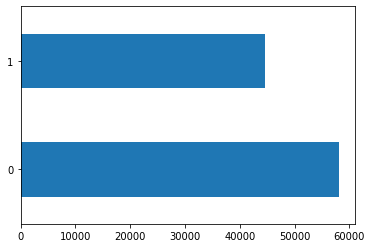

In [9]:
data["target"].value_counts().plot(kind='barh')

## Base Line

### Modelo aleatorio

In [10]:
def aleatorio_predict(X):
  return np.array([np.random.randint(0,3) for i in range(X.shape[0])])

In [11]:
y_pred_aleat = aleatorio_predict(X_test_new)
print(f'The f1 aleatorio :{f1_score(y_test, y_pred_aleat, average="macro")}')

The f1 aleatorio :0.2644720571402383


### Dumb Model

In [18]:
y_test.value_counts()

0    17423
1    13395
Name: target, dtype: int64

In [19]:
def dumb_predict(X):
  return np.array([0 for i in range(X.shape[0])])

In [20]:
y_pred_dumb = dumb_predict(X_test_new)
print(f'The f1 Dumb :{f1_score(y_test, y_pred_dumb, average="macro")}')

The f1 Dumb :0.3611658133123277


# Model

In [ ]:
scores_y0 = []
RF = RandomForestClassifier(class_weight="balanced")
RF.fit(X_train_new, y_train)
scores_y0.append({
        'best_params':None,
        'F1_avg_macro': f1_score(y_test, RF.predict(X_test_new), average='macro'),
        'accuracy_score':accuracy_score(y_test, RF.predict(X_test_new)),
        'F1_aleatorio':f1_score(y_test, y_pred_aleat, average="macro"),
        'F1_Dumb':f1_score(y_test, y_pred_dumb, average="macro")
    })
scores_df_y0 = pd.DataFrame(scores_y0, columns=['best_params', 'F1_avg_macro','accuracy_score','F1_aleatorio','F1_Dumb'])

In [ ]:
scores_df_y0

# GridSearchCV

## First interaction

In [ ]:
RF = RandomForestClassifier()
param_grid = { 
    'n_estimators': [90,100, 120],
    'criterion' :['gini', 'entropy'],
    'max_depth' : [10,15,20],
    'min_samples_split' : [2,5,8],
    'min_samples_leaf' : [1,2,3],
    'class_weight' : ['balanced','balanced_subsample'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_jobs' : [-1,1 ] 
}

CV_rfc = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='f1_macro')
CV_rfc.fit(X_train_new, y_train)
print(f"The f1:{f1_score(y_test, CV_rfc.best_estimator_.predict(X_test_new), average='macro')}")
print(f"CV_rfc.best_params_" ,CV_rfc.best_params_)

### Result

In [ ]:
print(f"The f1:{f1_score(y_test, CV_rfc.best_estimator_.predict(X_test_new), average='macro')}")
scores_y0.append({
        'best_params':CV_rfc.best_params_,
        'F1_avg_macro': f1_score(y_test, CV_rfc.best_estimator_.predict(X_test_new), average='macro'),
        'accuracy_score': accuracy_score(y_test, CV_rfc.best_estimator_.predict(X_test_new)),
        'F1_aleatorio': f1_score(y_test, y_pred_aleat, average="macro"),
        'F1_Dumb': f1_score(y_test, y_pred_dumb, average="macro")
    })
scores_df_y0 = pd.DataFrame(scores_y0, columns=['best_params', 'F1_avg_macro','accuracy_score','F1_aleatorio','F1_Dumb'])

In [ ]:
scores_df_y0

# Final result

In [ ]:
RF = RandomForestClassifier(class_weight='balanced_subsample',criterion='gini',max_features='log2',min_samples_leaf=2,min_samples_split=5,n_estimators=100,n_jobs=1,max_depth=10)
RF.fit(X_train_new, y_train)
scores_y0.append({
        'best_params': "GridSearchCV params",
        'F1_avg_macro': f1_score(y_test, RF.predict(X_test_new), average='macro'),
        'accuracy_score':accuracy_score(y_test, RF.predict(X_test_new)),
        'F1_aleatorio':f1_score(y_test, y_pred_aleat, average="macro"),
        'F1_Dumb':f1_score(y_test, y_pred_dumb, average="macro")
    })
scores_df_y0 = pd.DataFrame(scores_y0, columns=['best_params', 'F1_avg_macro','accuracy_score','F1_aleatorio','F1_Dumb'])

In [ ]:
scores_df_y0

In [ ]:
print(f"The f1:{f1_score(y_test, RF.predict(X_test_new), average='macro')}")

# XGBClassifier

In [12]:
import xgboost as xgb

from xgboost import XGBClassifier

random_state = np.random.randint(0, 1000)
xgb_model = XGBClassifier()


xgb_model.fit(X_train_new, y_train,verbose=False)
print(f"The f1:{f1_score(y_test, xgb_model.predict(X_test_new), average='macro')}")


/home/fernando/.pyenv/versions/3.8.6/envs/from_shelter_to_love/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:24:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The f1:0.6324879804682808


In [13]:
from xgboost import XGBClassifier
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1_macro',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [ ]:
grid_search.fit(X_train_new, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/home/fernando/.pyenv/versions/3.8.6/envs/from_shelter_to_love/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
f1_score(y_test, grid_search.best_estimator_.predict(X_test_new), average='macro')

In [ ]:
print(f"grid_search.best_params_" ,grid_search.best_params_)

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective= 'binary:logistic',
    learning_rate=0.1,
    max_depth=5,
    n_estimators= 180)


xgb_model.fit(X_train_new, y_train,verbose=True)
print(f"The f1:{f1_score(y_test, xgb_model.predict(X_test_new), average='macro')}")

In [ ]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters =  {
            'max_depth': [5],
            'learning_rate': [0.1, 0.2, 0.3],
            'n_estimators': [150, 180, 200],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [0, 0.5, 1],
            'max_delta_step': [0],
            'subsample': [0.7, 0.8, 0.9, 1],
            'colsample_bytree': [0.6, 0.8, 1],
            'colsample_bylevel': [1],
            'reg_alpha': [0, 1e-2, 1, 1e1],
            'reg_lambda': [0, 1e-2, 1, 1e1],
            'base_score': [0.5]
            }
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1_macro',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [ ]:
grid_search.fit(X_train_new, y_train)

In [ ]:
f1_score(y_test, grid_search.best_estimator_.predict(X_test_new), average='macro')